# 2024-1 DSL 정규세션 과제

## SVM

- 작성자 : 윤형진
- 참고자료 : sklearn document
- 과제 제출 기한 : 02.03

---
- 이름 :     박종락
- 기수 :     11기



In [69]:
#pip install umap-learn

In [70]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

# 1. SVM을 이용한 심장병 예측 모델

해당 섹션에서는 범주형 데이터 더미 변수화, 전처리, train_test_split, confusion matrix까지 그려보는 전체적인 머신러닝 프로젝트 과정을 실습해보도록 하겠습니다.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
import seaborn as sns
import umap

In [72]:
# heart.csv 데이터셋을 로드해주세요
df = pd.read_csv('/Users/jrock/Documents/Yonsei/DSL/과제/기초과제 3/회귀_SVM_비지도 통합과제/SVM/heart.csv')
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

## 데이터 전처리
- 범주형 데이터 : pd.get_dummies(데이터 프레임, columns = 범주형 데이터를 담은 칼럼들의 리스트, drop_first = True)
- 데이터 스케일링 : 연속형 데이터에 대해서 스케일링

In [73]:
label = df["HeartDisease"]

df_processed = df.drop(columns=["HeartDisease"])

# 범주형 데이터를 전처리해줍니다
categorical_col =  ["Sex", "ChestPainType", "RestingECG" , "ExerciseAngina" , "ST_Slope" ]

df_processed=pd.get_dummies(df_processed,columns=categorical_col,drop_first=True)

# 데이터 스케일링
scaler = StandardScaler()

for feature in ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]:
    df_processed[feature] = scaler.fit_transform(pd.DataFrame(df_processed[feature]))

df_processed["HeartDisease"] = label

df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    float64
 1   RestingBP          918 non-null    float64
 2   Cholesterol        918 non-null    float64
 3   FastingBS          918 non-null    float64
 4   MaxHR              918 non-null    float64
 5   Oldpeak            918 non-null    float64
 6   Sex_M              918 non-null    uint8  
 7   ChestPainType_ATA  918 non-null    uint8  
 8   ChestPainType_NAP  918 non-null    uint8  
 9   ChestPainType_TA   918 non-null    uint8  
 10  RestingECG_Normal  918 non-null    uint8  
 11  RestingECG_ST      918 non-null    uint8  
 12  ExerciseAngina_Y   918 non-null    uint8  
 13  ST_Slope_Flat      918 non-null    uint8  
 14  ST_Slope_Up        918 non-null    uint8  
 15  HeartDisease       918 non-null    int64  
dtypes: float64(6), int64(1), u

In [74]:
df_processed.head()

Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  Sex_M  \
0 -1.433140   0.410909     0.825070  -0.551341  1.382928 -0.832432      1   
1 -0.478484   1.491752    -0.171961  -0.551341  0.754157  0.105664      0   
2 -1.751359  -0.129513     0.770188  -0.551341 -1.525138 -0.832432      1   
3 -0.584556   0.302825     0.139040  -0.551341 -1.132156  0.574711      0   
4  0.051881   0.951331    -0.034755  -0.551341 -0.581981 -0.832432      1   

   ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  RestingECG_Normal  \
0                  1                  0                 0                  1   
1                  0                  1                 0                  1   
2                  1                  0                 0                  0   
3                  0                  0                 0                  1   
4                  0                  1                 0                  1   

   RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  ST_Slope_Up  HeartDisease  
0              0                 0              0            1             0  
1              0                 0              1            0             1  
2              1                 0              0            1             0  
3              0                 1              1            0             1  
4              0                 0              0            1             0

## Train dataset, Test Dataset 분할

In [75]:
train, test = train_test_split(df_processed, test_size=0.2, random_state=777)

print(f"Train Dataset Size : {train.shape}", f"Test Dataset Size : {test.shape}")

Train Dataset Size : (734, 16) Test Dataset Size : (184, 16)


In [76]:
x_train, y_train = train.iloc[:, :-1], train.iloc[:,-1]
x_test, y_test = test.iloc[:, :-1], test.iloc[:,-1]

## 다양한 조건으로 실험 진행

In [77]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report

In [78]:
def Run_Classification(name : str, model : object, x_train : object, y_train : object, x_test:object, y_test:object):

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_matrix = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='crest', linewidth=.5)
    cf_matrix = cf_matrix.get_figure()

    print(f"Classification Result of {name}", "\n")
    print(f"accuracy : {acc}", "\n")
    print(f"report : {report}", "\n")

    plt.show()
    plt.close()

    print("-"*100)

# 커널의 종류에 따른 모델 퍼포먼스 비교

Classification Result of linear 

accuracy : 0.8152173913043478 

report :               precision    recall  f1-score   support

           0       0.84      0.74      0.79        85
           1       0.80      0.88      0.84        99

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.82      0.81       184
 



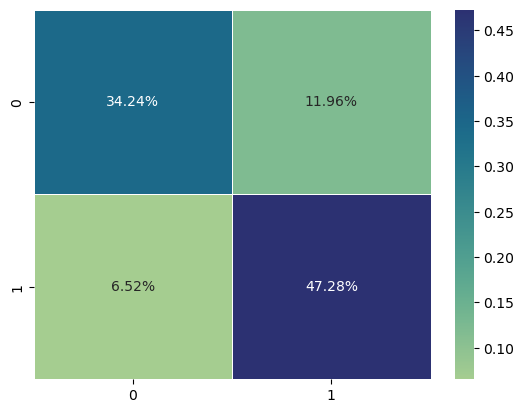

----------------------------------------------------------------------------------------------------
Classification Result of rbf_kernel 

accuracy : 0.8695652173913043 

report :               precision    recall  f1-score   support

           0       0.89      0.82      0.85        85
           1       0.86      0.91      0.88        99

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184
 



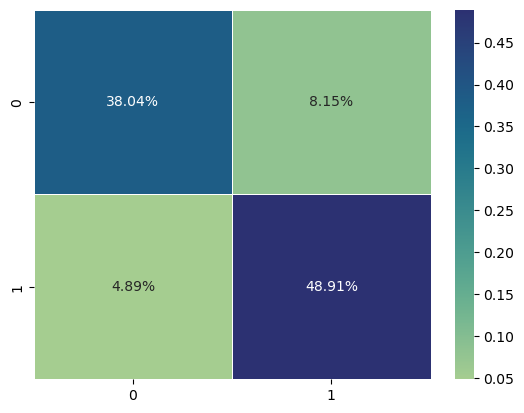

----------------------------------------------------------------------------------------------------
Classification Result of poly_kernel 

accuracy : 0.8586956521739131 

report :               precision    recall  f1-score   support

           0       0.87      0.81      0.84        85
           1       0.85      0.90      0.87        99

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184
 



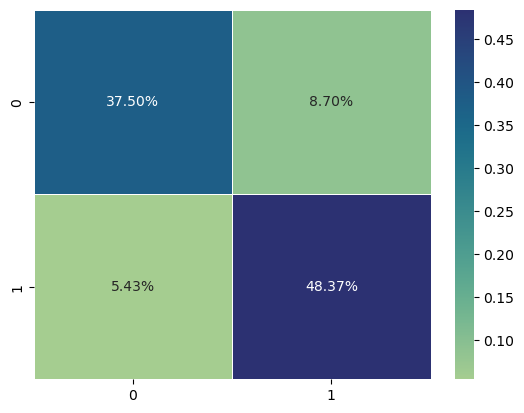

----------------------------------------------------------------------------------------------------


In [79]:
kernel_models = {"linear" : SVC(kernel="linear"),
                 "rbf_kernel" : SVC(kernel="rbf"),
                 "poly_kernel" : SVC(kernel="poly")}

for kernel_type, model in kernel_models.items():
  Run_Classification(kernel_type, model, x_train, y_train, x_test, y_test)

## C Parameter와 Soft/Hard Margin SVM
- C parameter는 SVM의 Regularization 파라미터로서, 클수록 Hard Margin SVM의 방향으로 학습됩니다.
<br>
(즉, 테스트 데이터셋에서 한 개의 miss-classification도 허용하지 않는 방향으로)
<br>
    - 이상치가 적은 경우 : 큰 C
    <br>
    - 이상치가 많은 경우 : 작은 C

Classification Result of rbf_SVC_C=0.5 

accuracy : 0.8532608695652174 

report :               precision    recall  f1-score   support

           0       0.87      0.80      0.83        85
           1       0.84      0.90      0.87        99

    accuracy                           0.85       184
   macro avg       0.86      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184
 



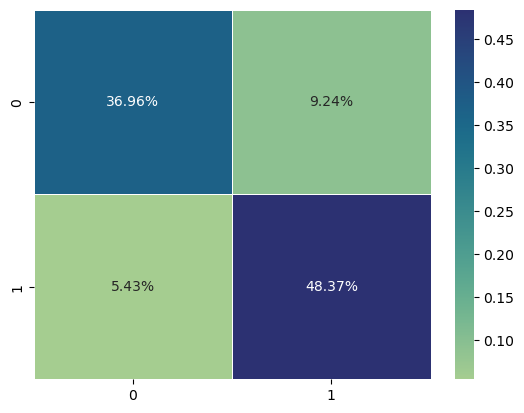

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_C=1 

accuracy : 0.8695652173913043 

report :               precision    recall  f1-score   support

           0       0.89      0.82      0.85        85
           1       0.86      0.91      0.88        99

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184
 



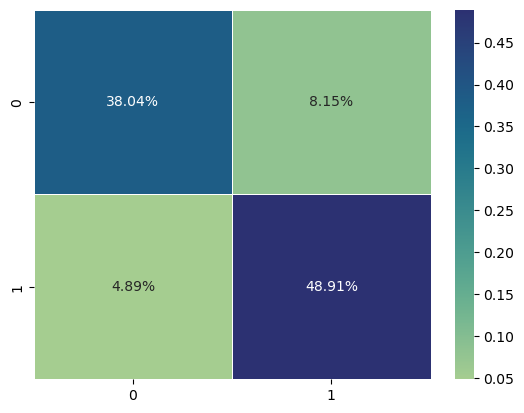

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_C=3 

accuracy : 0.8532608695652174 

report :               precision    recall  f1-score   support

           0       0.88      0.79      0.83        85
           1       0.83      0.91      0.87        99

    accuracy                           0.85       184
   macro avg       0.86      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184
 



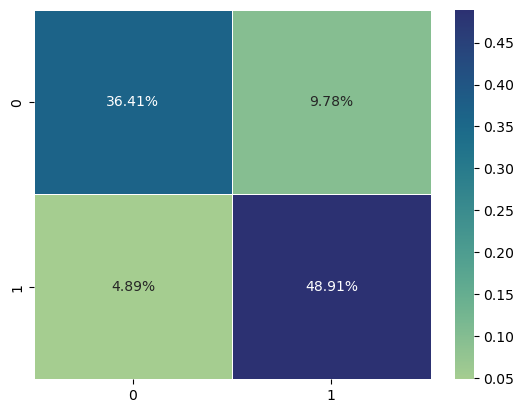

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_C=4 

accuracy : 0.842391304347826 

report :               precision    recall  f1-score   support

           0       0.86      0.79      0.82        85
           1       0.83      0.89      0.86        99

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184
 



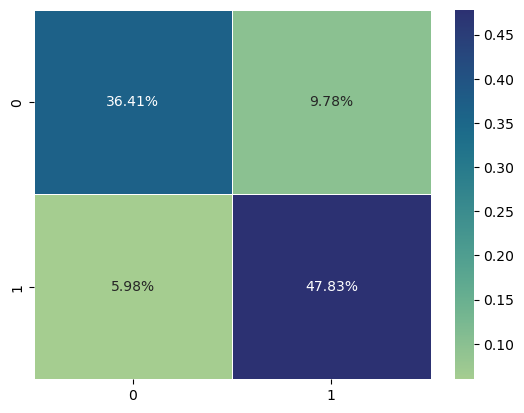

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_C=5 

accuracy : 0.842391304347826 

report :               precision    recall  f1-score   support

           0       0.86      0.79      0.82        85
           1       0.83      0.89      0.86        99

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184
 



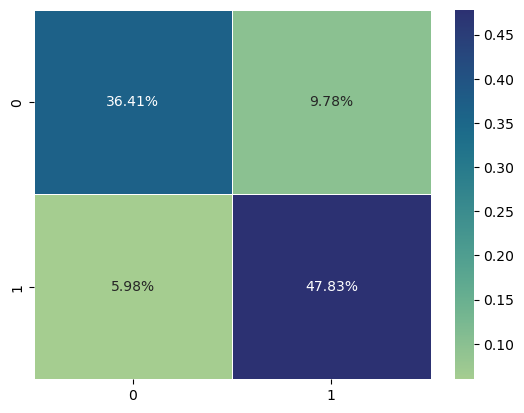

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_C=10 

accuracy : 0.8260869565217391 

report :               precision    recall  f1-score   support

           0       0.84      0.78      0.80        85
           1       0.82      0.87      0.84        99

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.82       184
weighted avg       0.83      0.83      0.83       184
 



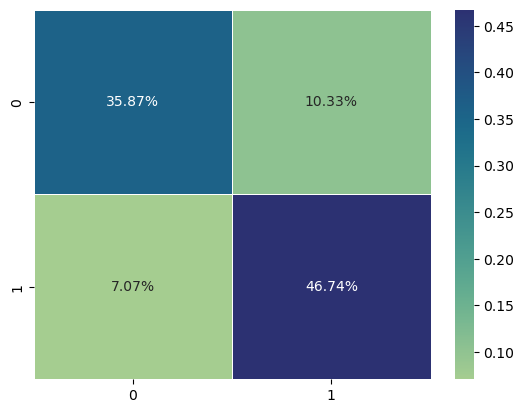

----------------------------------------------------------------------------------------------------


In [80]:
c_models = {'rbf_SVC_C=0.5': SVC(C=0.5),
            'rbf_SVC_C=1': SVC(C=1),
            'rbf_SVC_C=3': SVC(C=3),
            'rbf_SVC_C=4': SVC(C=4),
            'rbf_SVC_C=5': SVC(C=5),
            'rbf_SVC_C=10': SVC(C=10)}

for name, model in c_models.items():
  Run_Classification(name, model, x_train, y_train, x_test, y_test)

# gamma 파라미터와 RBF Kernel

RBF 함수가 각 데이터 포인트와 이웃 데이터 포인트의 유사도를 계산하는 함수의 일종이었다는 걸 기억하시나요?
gamma 파라미터는 그중에서도 한 데이터 포인트로부터 유사하다고 판단되는 거리를 조절하는 파람미터로, gamma가 커질수록 더 좁은 반경의 데이터 포인트만을 유사하다고 판단하게 됩니다.

<br>

즉, gamma가 클수록, 경계곡면 (decision boundary)는 데이터의 분포에 더 예민하게 반응하여, 더 굴곡지게 됩니다. 따라서 적절한 크기의 gamma는 더 정확한 경계곡면이 학습되도록 도와줄 수도 있지만, 과도한 경우 overfitting을 야기시킵니다.

Classification Result of rbf_SVC_gamma=0.2 

accuracy : 0.8695652173913043 

report :               precision    recall  f1-score   support

           0       0.90      0.81      0.85        85
           1       0.85      0.92      0.88        99

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184
 



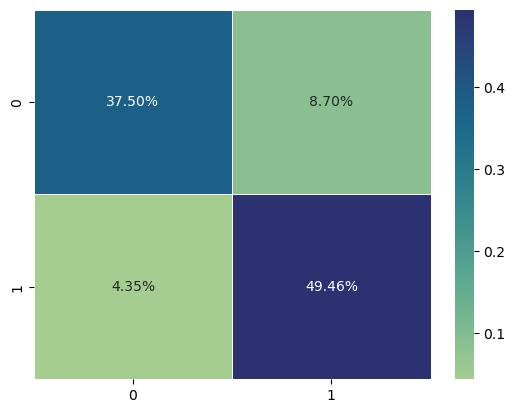

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_gamma=0.5 

accuracy : 0.8152173913043478 

report :               precision    recall  f1-score   support

           0       0.87      0.71      0.78        85
           1       0.78      0.91      0.84        99

    accuracy                           0.82       184
   macro avg       0.83      0.81      0.81       184
weighted avg       0.82      0.82      0.81       184
 



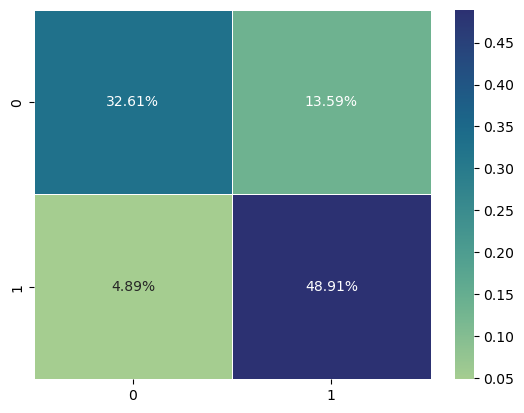

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_gamma=1 

accuracy : 0.7608695652173914 

report :               precision    recall  f1-score   support

           0       0.87      0.56      0.69        85
           1       0.71      0.93      0.81        99

    accuracy                           0.76       184
   macro avg       0.79      0.75      0.75       184
weighted avg       0.79      0.76      0.75       184
 



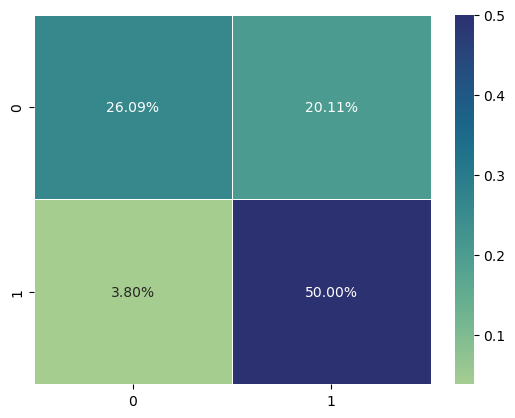

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_gamma=4 

accuracy : 0.5978260869565217 

report :               precision    recall  f1-score   support

           0       0.87      0.15      0.26        85
           1       0.57      0.98      0.72        99

    accuracy                           0.60       184
   macro avg       0.72      0.57      0.49       184
weighted avg       0.71      0.60      0.51       184
 



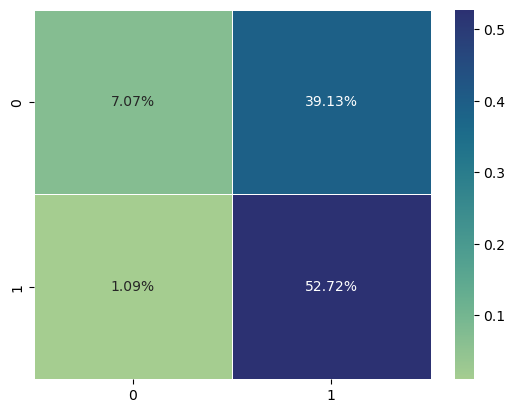

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_gamma=8 

accuracy : 0.5652173913043478 

report :               precision    recall  f1-score   support

           0       1.00      0.06      0.11        85
           1       0.55      1.00      0.71        99

    accuracy                           0.57       184
   macro avg       0.78      0.53      0.41       184
weighted avg       0.76      0.57      0.43       184
 



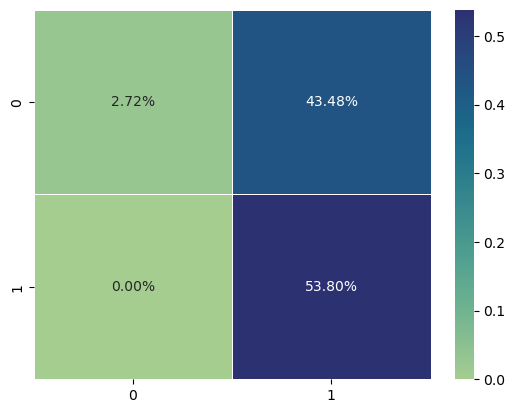

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_gamma=16 

accuracy : 0.5652173913043478 

report :               precision    recall  f1-score   support

           0       1.00      0.06      0.11        85
           1       0.55      1.00      0.71        99

    accuracy                           0.57       184
   macro avg       0.78      0.53      0.41       184
weighted avg       0.76      0.57      0.43       184
 



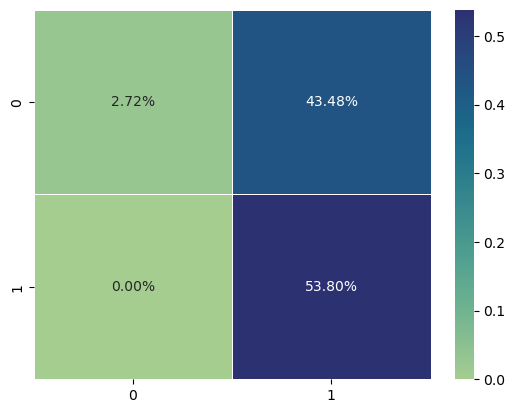

----------------------------------------------------------------------------------------------------


In [98]:
gamma_models = {'rbf_SVC_gamma=0.2': SVC(gamma=0.2),
                'rbf_SVC_gamma=0.5': SVC(gamma=0.5),
                'rbf_SVC_gamma=1': SVC(gamma=1),
                'rbf_SVC_gamma=4': SVC(gamma=4),
                'rbf_SVC_gamma=8': SVC(gamma=8),
                'rbf_SVC_gamma=16': SVC(gamma=16)}

for name, model in gamma_models.items():
  Run_Classification(name, model, x_train, y_train, x_test, y_test)

Classification Result of rbf_SVC_gamma=0.2 

accuracy : 0.8206521739130435 

report :               precision    recall  f1-score   support

           0       0.85      0.74      0.79        85
           1       0.80      0.89      0.84        99

    accuracy                           0.82       184
   macro avg       0.83      0.82      0.82       184
weighted avg       0.82      0.82      0.82       184
 



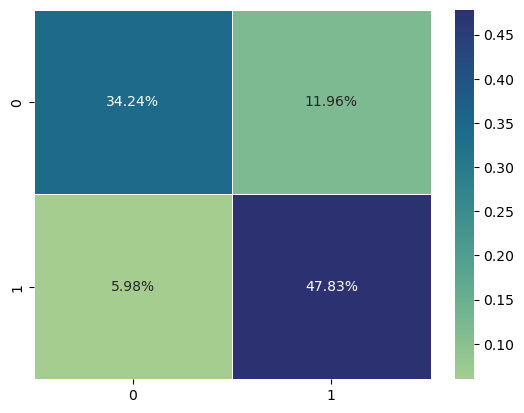

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_gamma=0.5 

accuracy : 0.8532608695652174 

report :               precision    recall  f1-score   support

           0       0.87      0.80      0.83        85
           1       0.84      0.90      0.87        99

    accuracy                           0.85       184
   macro avg       0.86      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184
 



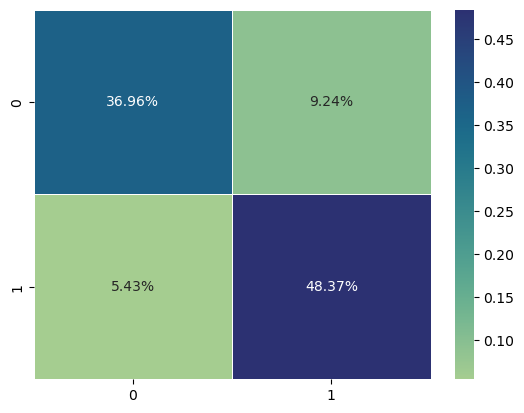

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_gamma=1 

accuracy : 0.8695652173913043 

report :               precision    recall  f1-score   support

           0       0.89      0.82      0.85        85
           1       0.86      0.91      0.88        99

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184
 



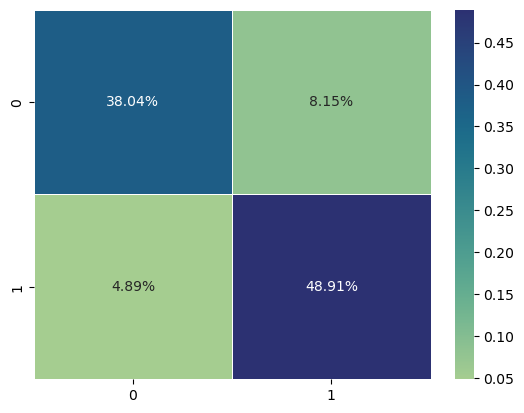

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_gamma=4 

accuracy : 0.842391304347826 

report :               precision    recall  f1-score   support

           0       0.86      0.79      0.82        85
           1       0.83      0.89      0.86        99

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184
 



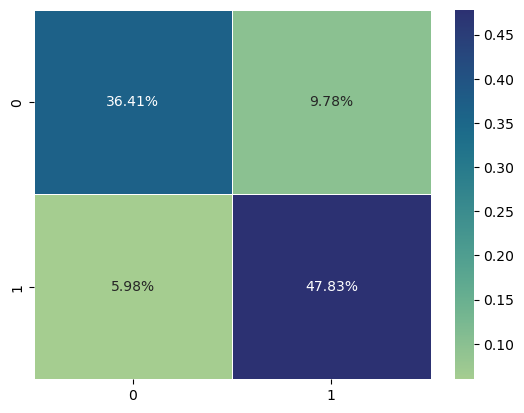

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_gamma=8 

accuracy : 0.8315217391304348 

report :               precision    recall  f1-score   support

           0       0.84      0.79      0.81        85
           1       0.83      0.87      0.85        99

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184
 



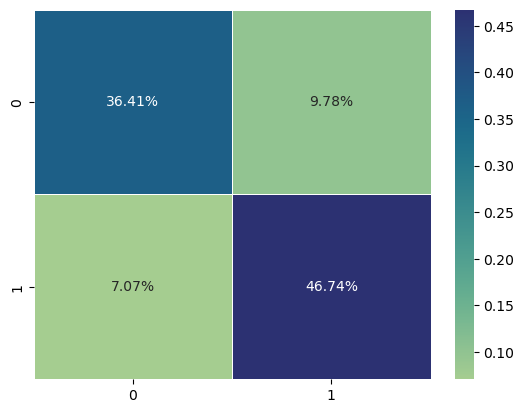

----------------------------------------------------------------------------------------------------
Classification Result of rbf_SVC_gamma=16 

accuracy : 0.8260869565217391 

report :               precision    recall  f1-score   support

           0       0.83      0.79      0.81        85
           1       0.83      0.86      0.84        99

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.82       184
weighted avg       0.83      0.83      0.83       184
 



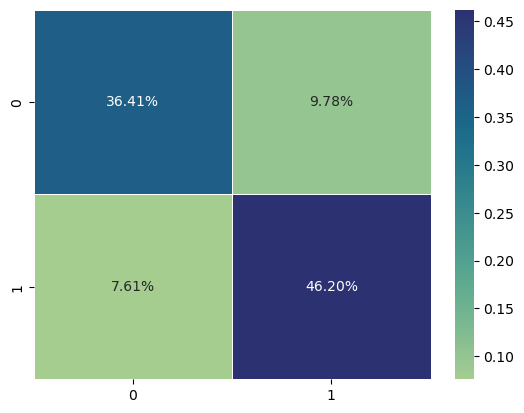

----------------------------------------------------------------------------------------------------


In [96]:
gamma_models = {'rbf_SVC_gamma=0.2': SVC(C=0.2),
                'rbf_SVC_gamma=0.5': SVC(C=0.5),
                'rbf_SVC_gamma=1': SVC(C=1),
                'rbf_SVC_gamma=4': SVC(C=4),
                'rbf_SVC_gamma=8': SVC(C=8),
                'rbf_SVC_gamma=16': SVC(C=16)}

for name, model in gamma_models.items():
  Run_Classification(name, model, x_train, y_train, x_test, y_test)

# 2. 여러 파라미터에 의한 결정 경계 변화 시각화

일전에 C 파라미터를 통한 Soft/Harm Margin SVM 조절을, gamma 파라미터를 통해 경계곡면의 굴곡도를 조정하는 것이 Model Metric에 어떤 영향을 주는 지 관찰했습니다. 이 변화를 시각화하기 위해서는 15 차원인 데이터를 2차원으로 축소할 필요가 있습니다.

<br>

해당 섹션에서는 UMAP의 힘을 빌려 파라미터 변화에 따른 경계곡면의 변화 양상을 시각화하도록 하겠습니다.

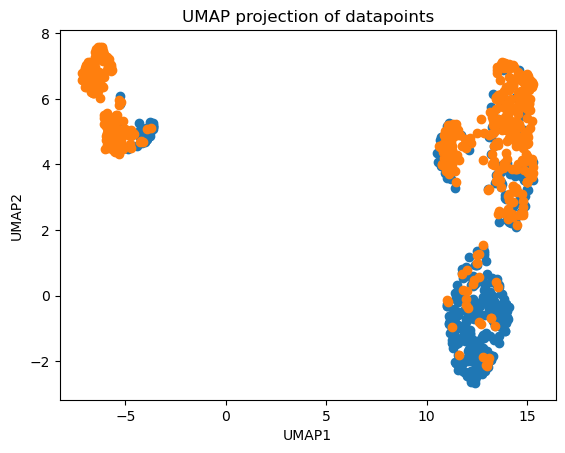

In [82]:
umap_instance = umap.UMAP(metric="cosine")
embedding = umap_instance.fit_transform(df_processed.iloc[:, :-1])
embedding_df = pd.DataFrame(embedding)
embedding_df["HeartDisease"] = df_processed["HeartDisease"]

# Get unique classes
classes = embedding_df["HeartDisease"].unique()

# Create a scatter plot for each class
for i, class_ in enumerate(classes):
    plt.scatter(embedding_df[embedding_df["HeartDisease"]==class_].iloc[:,0],
                embedding_df[embedding_df["HeartDisease"]==class_].iloc[:,1],
                label=f'Class {class_}')

plt.title('UMAP projection of datapoints')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()


In [83]:
Utrain, Utest = train_test_split(embedding_df, test_size = 0.3, random_state=777)

x_Utrain, y_Utrain = Utrain.iloc[:, :-1], Utrain.iloc[:,-1]
x_Utest,  y_Utest  = Utest.iloc[:, :-1],  Utest.iloc[:,-1]

## 2-1. Kernel 종류에 따른 경계 곡면 변화 시각화

In [84]:
models = dict()

models["rbf"] = SVC(C = 4,  kernel="rbf")
models["poly"] = SVC(C = 4, kernel="poly")
models["linear"] = SVC(C=4, kernel="linear")

poly_svc = models["poly"].fit(x_Utrain, y_Utrain)
rbf_svc = models["rbf"].fit(x_Utrain, y_Utrain)
linear_svc = models["linear"].fit(x_Utrain, y_Utrain)

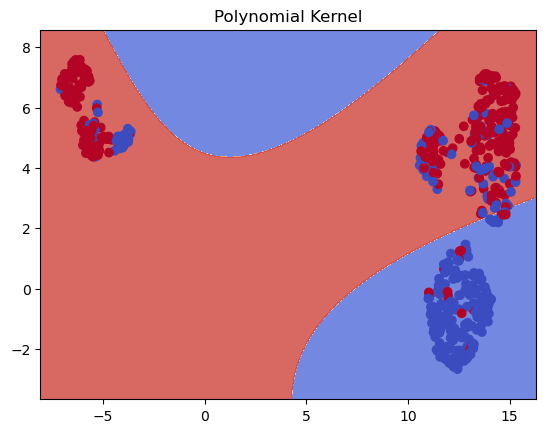

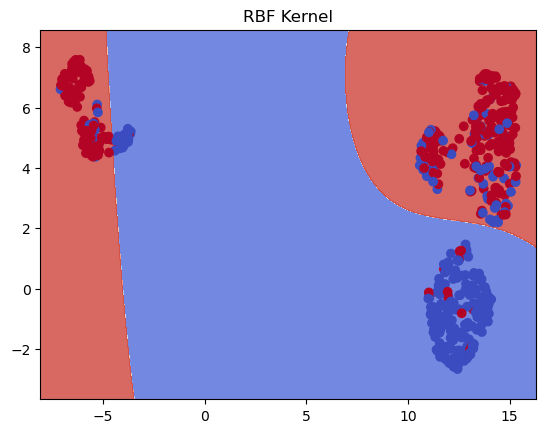

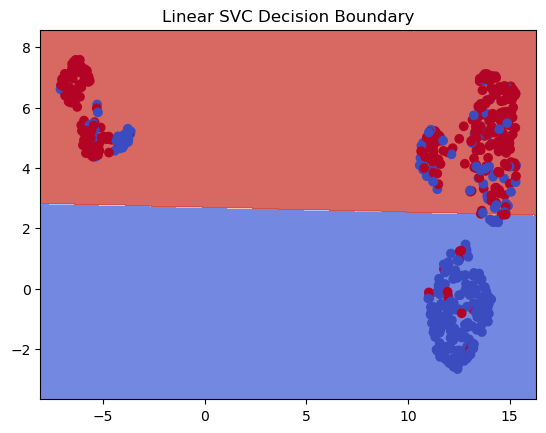

In [85]:
h = .02
x_min, x_max = x_Utrain.iloc[:, 0].min() - 1, x_Utrain.iloc[:, 0].max() + 1
y_min, y_max = x_Utrain.iloc[:, 1].min() - 1, x_Utrain.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot the decision boundary for polynomial kernel
Z = poly_svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(x_Utrain.iloc[:, 0], x_Utrain.iloc[:, 1], c=y_Utrain, cmap=plt.cm.coolwarm)
plt.title('Polynomial Kernel')
plt.show()

# Plot the decision boundary for RBF kernel
Z = rbf_svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(x_Utrain.iloc[:, 0], x_Utrain.iloc[:, 1], c=y_Utrain, cmap=plt.cm.coolwarm)
plt.title('RBF Kernel')
plt.show()

# Plot the decision boundary for linear kernel
Z = linear_svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(x_Utrain.iloc[:, 0], x_Utrain.iloc[:, 1], c=y_Utrain, cmap=plt.cm.coolwarm)
plt.title('Linear SVC Decision Boundary')
plt.show()

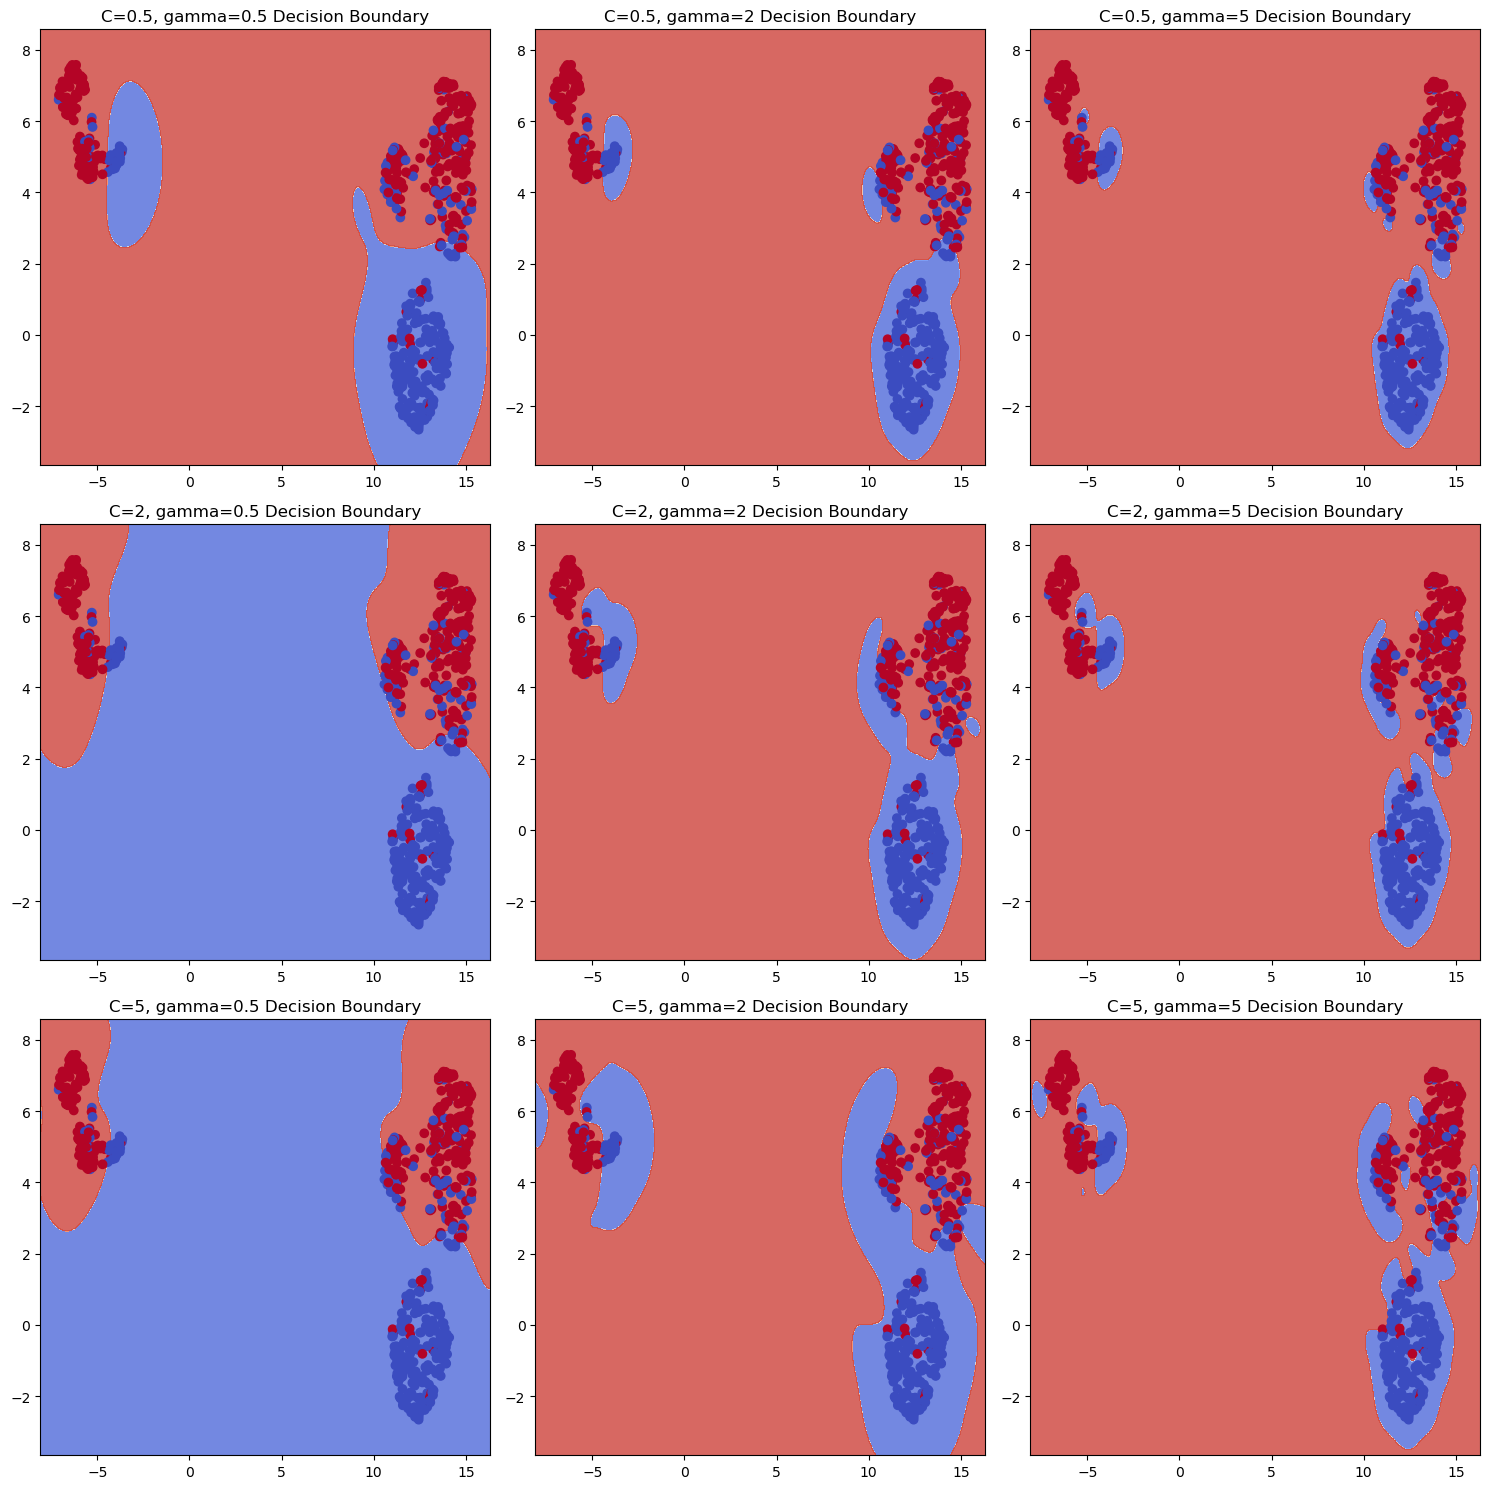

In [86]:
rbf_models = {"C=0.5, gamma=0.5" : SVC(C=0.5, gamma = 0.5, kernel="rbf"), "C=0.5, gamma=2"  : SVC(C=0.5, gamma = 2, kernel="rbf"), "C=0.5, gamma=5" : SVC(C=0.5, gamma = 5, kernel="rbf"),
              "C=2, gamma=0.5"   : SVC(C=2, gamma = 0.5, kernel="rbf"),   "C=2, gamma=2"    : SVC(C=2, gamma = 2, kernel="rbf"),   "C=2, gamma=5"   : SVC(C=2, gamma = 5, kernel="rbf"),
              "C=5, gamma=0.5"   : SVC(C=5, gamma = 0.5, kernel="rbf"),   "C=5, gamma=2"   : SVC(C=5, gamma = 2, kernel="rbf"),   "C=5, gamma=5"   : SVC(C=5, gamma = 5, kernel="rbf")}

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()

for i, (name, model) in enumerate(rbf_models.items()):
  rbf_svc = model.fit(x_Utrain, y_Utrain)

  h = .02
  x_min, x_max = x_Utrain.iloc[:, 0].min() - 1, x_Utrain.iloc[:, 0].max() + 1
  y_min, y_max = x_Utrain.iloc[:, 1].min() - 1, x_Utrain.iloc[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


  Z = rbf_svc.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  axs[i].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
  axs[i].scatter(x_Utrain.iloc[:, 0], x_Utrain.iloc[:, 1], c=y_Utrain, cmap=plt.cm.coolwarm)
  axs[i].set_title(f'{name} Decision Boundary')

plt.tight_layout()
plt.show()


# 3. 문제
위의 예시를 참고하여 적절한 파라미터를 가진 SVC를 이용해 87% 이상의 accuracy를 내도록 하십시오. accuracy, f1 score와 함께 confusion matrix도 함께 plot 해주세요.

(Run_Classification() 함수를 사용해도 좋습니다.)

In [114]:
##Grid_search 활용
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.5, 1, 3, 4, 5, 10], 'gamma': [0.2, 0.5, 1, 4, 8, 16]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [115]:
best_params

{'C': 1, 'gamma': 0.2}

Classification Result of rbf_SVC_gamma=0.2_C=1 

accuracy : 0.8695652173913043 

report :               precision    recall  f1-score   support

           0       0.90      0.81      0.85        85
           1       0.85      0.92      0.88        99

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184
 



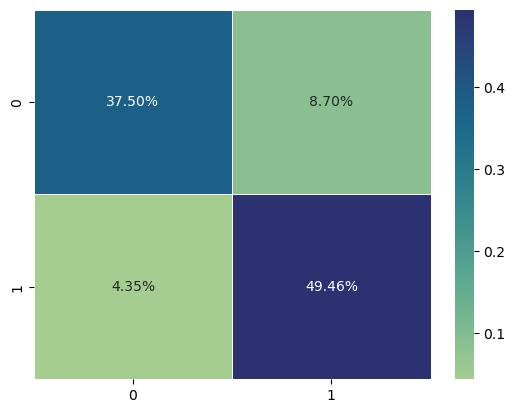

----------------------------------------------------------------------------------------------------


In [136]:
models = {'rbf_SVC_gamma=0.2_C=1': SVC(gamma= 0.2, C=1)}

for name, model in models.items():
  Run_Classification(name, model, x_train, y_train, x_test, y_test)

In [139]:
##RandomizedSerchCV 활용
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_dist = {'C': reciprocal(0.1, 100), 'gamma': reciprocal(0.1, 10)}
random_search = RandomizedSearchCV(SVC(), param_dist, cv=5, n_iter=20, scoring='accuracy')
random_search.fit(x_train, y_train)
best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [140]:
best_params

{'C': 0.45455539003928963, 'gamma': 0.23333245186851467}

In [141]:
best_model

SVC(C=0.45455539003928963, gamma=0.23333245186851467)

Classification Result of rbf_SVC_gamma 

accuracy : 0.842391304347826 

report :               precision    recall  f1-score   support

           0       0.88      0.76      0.82        85
           1       0.82      0.91      0.86        99

    accuracy                           0.84       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.84      0.84       184
 



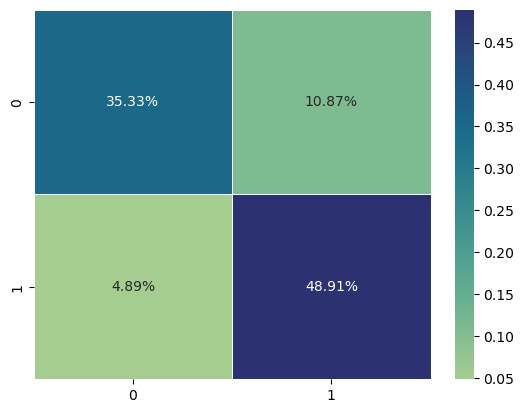

----------------------------------------------------------------------------------------------------


In [147]:
models = {'rbf_SVC_gamma': SVC(gamma= 0.23333245186851467, C=0.45455539003928963)}

for name, model in models.items():
  Run_Classification(name, model, x_train, y_train, x_test, y_test)